# Basic Neural Network
This python notebok contains code for very basic neural network with explanations of the underlining concepts. The network is design to recognize handwritten digits from the MNIST dataset. Each digit is a 28x28 monochrome picture.

It is a fully connected neural network programed mainly using numpy and its matrix operations. The code is not written convntionally as you would encounter in popular neural network/machine learning libraries, but hopefuly easier to understand. Slight modifications can be made, so that the network could be used for any reasonable dataset, although the results might not be amazing.

### Letarature
https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

https://video1.fit.vutbr.cz/av/records-categ.php?id=1840

https://hmkcode.com/ai/backpropagation-step-by-step/

In [16]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import random as rnd
import numpy.typing as npt

L1_SIZE = 56
L2_SIZE = 28
IMAGE_EDGE_SIZE = 28
PIXELS_PER_IMAGE = IMAGE_EDGE_SIZE ** 2
CLASSES_COUNT = 10
ITERATIONS = 500
LEARNING_RATE = 0.15

### Helper functions

In [17]:
def one_hot(labels: npt.ArrayLike) -> npt.NDArray:
    """
    Converts a 1D array of labels (the ground truth) to 2D matrix of shape (10, labels.size) as a probability distribution, 
    where the corresponding row given by the label value has probability of 1.
    
    :labels: The ground truth.
    :return: Encoded values of labels to probability distribution.
    """
    one_hot = np.zeros((10, labels.size))
    one_hot[labels, np.arange(labels.size)] = 1
    return one_hot

def get_accuracy(results: npt.NDArray, labels: npt.ArrayLike) -> float:
    """
    Calculates the accuracy of a neural network from the results of classification by comparing it to the ground truth.

    :results: The forward propagation results.
    :labels: The ground truth labels.
    :return: The accuracy as a real number between 0 and 1. 
    """
    return (np.sum(np.argmax(results, 0) == labels) / labels.size)

def show_some_mistakes(results: npt.NDArray, labels: npt.ArrayLike, data: npt.NDArray, samples = 10) -> None:
    """
    Plots randomly choosen images, which were not classified correctly.

    :results: The forward propagation results.
    :labels: The ground truth.
    :data: The input data of forward propagation, i.e images.
    :samples: The number of shown images, 10 by default.
    """
    results = np.argmax(results, 0)
    i = rnd.randint(0, labels.size)
    j = 0
    while j < samples:
        i = (i + 1) % labels.size
        if results[i] != labels[i]:
            print("labeled:", labels[i], "-- classified:", results[i])
            plt.imshow(data[:, i].reshape((IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE)), cmap='gray')
            plt.show()
            j += 1

### Activation functions
These non-linear functions are used on outputs of each layer. Non-linearity is necessary, otherwise creating more layers does not yield better results, the same results could be calculated using just single layer with sufficient number of neurons.

In [18]:
def ReLU(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the Rectified Linear Units of a numpy matrix.
    
    :L: Matrix of values of a hidden layer.
    :return: For all nonnegative numbers returns its value, otherwise 0.
    """
    return np.maximum(0, L)

def ReLU_deriv(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the derivation of ReLu function of a numpy matrix.

    :L: Matrix of values of a hidden layer.
    :return: For all positive numbers returns 1, otherwise 0.
    """
    return L > 0

def sigmoid(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the Sigmoid function of a numpy matrix.
    
    :L: Values of a hidden layer.
    :return: For all indices with value x returns 1 / (1 + e^(-x)).
    """
    return 1 / (1 + np.exp(-L))

def sigmoid_deriv(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the derivative of the Sigmoid function of a numpy matrix.
    
    :L: Values of a hidden layer.
    :return: For all indices with value x returns (1 / (1 + e^(-x))) * (1 - (1 / (1 + e^(-x)))).
    """
    sigm = sigmoid(L)
    return sigm * (1 - sigm)

def softmax(L: npt.NDArray) -> npt.NDArray:
    """
    Converts a column of N values (in case of digits 10 values) to a probability distribution of N outcomes for each column of a matrix.
    Columns shoud be the outputs of a neural network.

    :L: Values of an output layer ordered into columns for each sample.
    :return: For all indices of the given matrix returns the probability of a given index in its column.
    """
    exp = np.exp(L)
    return exp / np.sum(exp, 0)

### Initialization of Weights And Biases, Explanation of Their Arrangement
Correct initialization of weights and biases is important as it can have severe impact on the performance of a neural network. Biases are usually initialized with zeros, as is also done here, weights are usually initialized randomly but in a more sofisticated way than how it is done below.

The calculation of output values (values of neurons) of a given layer is done in a following way. Given $I$ (let's say 20) input values and $O$ (let's say 10) output values, there is one weight for each input value per each output value (each input value has 10 weights, each output value has 20 weights, if inputs and outputs are nodes and weigths are edges, it is a complete bipartite graph), that is $W_{size} = I_{size} \cdot O_{size}$ (there are 200 weights). Biases are simplier, there is just one bias per output value (that is 10). First output value is calculated as the sum of all input values multiplied respectively by the first 20 weights and a bias: 
$$
o0 = w0 \cdot i0 + w1 \cdot i1 + w2 \cdot i2 + ... + w19 \cdot i19 + b0
$$
Similarly this must be done for the remaining 9 output values.

The calculation of all output values can be done simultaneously by a matrix multiplication (by the weights) and addition (of the biases), if the weights, biases and input values are arranged correctly. Input values must be arranged in a column vector (for the example that is 20 values) as well as the biases (10 values). Weights are arranged to a matrix, where the number of columns is the number of input values (that is 20 columns) and the number of rows is the number of output values of the given layer (that is 10). The matrix multiplication must be done in a correct order, so that the dimensions are correctly aligned, that is: 
$$
    O = 
    W \times I + B 
    = 
    \begin{bmatrix}
        w_{0} & w_{2} & \cdots & w_{19}\\
        w_{20} & w_{21} & \cdots & w_{39}\\ 
        \vdots & \vdots & \ddots & \vdots\\ 
        w_{80} & w_{81} & \cdots & w_{99} 
    \end{bmatrix}
    \times
    \begin{bmatrix}
        i_{0}\\
        i_{1}\\ 
        \vdots\\ 
        i_{19}
    \end{bmatrix}
    +
    \begin{bmatrix}
        b_{0}\\
        b_{1}\\ 
        \vdots\\ 
        b_{9}
    \end{bmatrix}
    =
    \begin{bmatrix}
        o_{0}\\
        o_{1}\\ 
        \vdots\\ 
        o_{9}
    \end{bmatrix}
$$
The output values are then arranged in a column vector (with 10 values), which is convinient, as this vector can be immidiately used as an input vector for next layer. The classification, which a neural network does, is done by chaining these matrix multiplications of each layer.

Note, that this input/output column vector holds values just for a single training sample (let's say the input values are values of pixels of a 4 by 5 image). Calculation of outputs for all (or any sufficient number - a batch) training samples simultaneously, as it is needed to perform the learning of a neural network, can be done by stacking more column vectors with values of training samples together, i.e. creating a matrix where each columns represent values for each training sample (let's say 1000 training samples, then the matrix has 20 rows - values of pixels; and 1000 columns - each for one training sample). Also note, that the indexing of scalar values inside matrices changed to a more consistent notation, that is indexing by rows and columns. It is good to notice the relation of $i$, $j$ and $k$ indices.
$$
    O = 
    W \times I + B 
    = 
    \begin{bmatrix}
        w_{00} & w_{01} & \cdots & w_{0j}\\
        w_{10} & w_{11} & \cdots & w_{0j}\\ 
        \vdots & \vdots & \ddots & \vdots\\ 
        w_{i0} & w_{i1} & \cdots & w_{ij} 
    \end{bmatrix}
    \times
    \begin{bmatrix}
        i_{00} & i_{01} & \cdots & i_{0k}\\
        i_{10} & i_{11} & \cdots & i_{1k}\\ 
        \vdots & \vdots & \ddots & \vdots\\ 
        i_{j0} & i_{j1} & \cdots & i_{jk} 
    \end{bmatrix}
    +
    \begin{bmatrix}
        b_{0}\\
        b_{1}\\ 
        \vdots\\ 
        b_{i}
    \end{bmatrix}
    =
    \begin{bmatrix}
        o_{00} & o_{01} & \cdots & o_{0k}\\
        o_{10} & o_{11} & \cdots & o_{1k}\\ 
        \vdots & \vdots & \ddots & \vdots\\ 
        o_{i0} & o_{i1} & \cdots & o_{ik} 
    \end{bmatrix}
$$

In [19]:
def weights_init_2L(size: int, input_size = PIXELS_PER_IMAGE, output_size = CLASSES_COUNT) -> tuple:
    """
    Randomly initilizes weights with real numbers between -0.5 and 0.5.

    :size: Number of neurons in a hidden layer.
    :input_size: Number of input values.
    :output_size: Number of neurons in an output layer.
    :return: Tuple of randomly initilized weight matrices with real numbers between -0.5 and 0.5.
    """
    # The number of rows of a weight matrix is alligned with the number of columns of the following matrix, as descibed above.
    W1 = np.random.rand(size, input_size) - 0.5  # matrix of 'size' rows and 'input_size' columns
    W2 = np.random.rand(output_size, size) - 0.5 # matrix of 'output_size' (number of classes, in case of digits - 10) rows and 'size' columns
    return W1, W2

def weights_init_3L(l1_size: int, l2_size: int, input_size = PIXELS_PER_IMAGE, output_size = CLASSES_COUNT) -> tuple:
    """
    Randomly initilizes weights with real numbers between -0.5 and 0.5.

    :l1_size: Number of neurons in a first hidden layer.
    :l2_size: Number of neurons in a second hidden layer.
    :input_size: Number of input values.
    :output_size: Number of neurons in an output layer.
    :return: Tuple of randomly initilized weight matrices with real numbers between -0.5 and 0.5.
    """
    # The number of rows of a weight matrix is alligned with the number of columns of the following matrix, as descibed above.
    W1 = np.random.rand(l1_size, input_size) - 0.5   # matrix of 'l1_size' rows and 'input_size' columns
    W2 = np.random.rand(l2_size, l1_size) - 0.5      # matrix of 'l2_size' rows and 'l1_size' columns
    W3 = np.random.rand(output_size, l2_size) - 0.5  # matrix of 'output_size' (number of classes, in case of digits - 10) rows and 'l2_size' columns
    return W1, W2, W3

def weights_init(sizes: list) -> list:
    """
    Randomly initilizes weights with real numbers between -0.5 and 0.5.

    :sizes: List of layer sizes, first value specifies number of input values, last value specifies number of output neurons. 
            The number of initilizes weight matrices is one less than lenght of the given list.
    :return: List of randomly initilized weight matrices with real numbers between -0.5 and 0.5.
    """
    weights = [] 
    for i in range(len(sizes) - 1):
        # The number of rows of a weight matrix is alligned with the number of columns of the following matrix, as descibed above.
        weights.append(np.random.rand(sizes[i + 1], sizes[i]) - 0.5)
    return weights

def biases_init_2L(size: int, output_size = 10) -> tuple:
    """
    Initilizes two bias column vectors with zeros.

    :size: Number of neurons in a hidden layer.
    :output_size: Number of neurons in an output layer.
    :return: Tuple of zero initilized bias vectors.
    """
    # Biases are column vectors, in numpy those are matrices with given number of rows and only one column.
    B1 = np.zeros((size, 1))          # matrix of 'size' rows and only one column
    B2 = np.zeros((output_size, 1))   # matrix of 'output_size' rows and only one column
    return B1, B2

def biases_init_3L(l1_size, l2_size, output_size = CLASSES_COUNT):
    """
    Initilizes three bias column vectors with zeros.

    :l1_size: Number of neurons in a first hidden layer.
    :l2_size: Number of neurons in a second hidden layer.
    :output_size: Number of neurons in an output layer.
    :return: Tuple of zero initilized bias vectors.
    """
    # Biases are column vectors, in numpy those are matrices with given number of rows and only one column.
    B1 = np.zeros((l1_size, 1))      # One bias for each neuron in the first hidden layer.
    B2 = np.zeros((l2_size, 1))      # One bias for each neuron in the second hidden layer.
    B3 = np.zeros((output_size, 1))  # One bias for each neuron in the output layer.
    return B1, B2, B3

def biases_init(sizes: list) -> tuple:
    """
    Initilizes bias column vectors with zeros.

    :size: List of layer sizes, first value specifies number of input values, last value specifies number of output neurons. 
           The number of initilizes weight matrices is one less than lenght of the given list.
    :return: List of zero initilized bias vectors.
    """
    biases = []
    # Biases are column vectors, in numpy those are matrices with given number of rows and only one column.
    for i in range(1, len(sizes)): # starting from 1, skipping the input value size
        biases.append(np.zeros((sizes[i], 1)))  
    return biases

### Forward propagation
Forward propagation is an algorithm, which calculates the output of a neural network for given input values. There are three operations successively performed for each layer, those are:
1. the matrix of input values or the output from previous layer is multiplied by the weight matrix of the respective layer,
2. biases of the respective layer are added to the result of matrix multiplication,
3. an activation functions is applied to the result.

The output values of a neural network with two hidden layer using ReLU as an activation function and an output layer with Softmax activation function would look like:
$$
O = softmax(W_3 \times ReLU(W_2 \times ReLU(W_1 \times I + B_1) + B_2) + B_3)
$$

Note that, on a trained neural network the resuts of any hidden layer can be discarder, after they were used for calculating the results of a next hidden layer, as only the results of the output layer are needed. But to train a neural network, values of all hiden layers must be stored. These values are then used to improve the weights and biases of the respective layer using algorithms called backpropagation and gradient descend, see below.

In [20]:
def forward_prop_2L(W1: npt.NDArray, W2: npt.NDArray, B1: npt.ArrayLike, B2: npt.ArrayLike, training_data: npt.ArrayLike) -> tuple:
    """
    Classifies all training samples in to classes according to the given weights and biases.

    :W1: First layer weight matrix.
    :W2: Second layer weight matrix.
    :B1: First layer bias column vector.
    :B2: Second layer bias column vector.
    :training_data: Training samples, each column represents one training sample.
    :return: Tuple of matrices with values for each layer.
    """
    L1 = ReLU(W1.dot(training_data) + B1) # L1 shape is: rows = W1.rows, cols = training_data.cols.
    L2 = softmax(W2.dot(L1) + B2)         # L2 shape is: rows = W2.rows (10 for digit classification), cols = training_data.cols.
    return L1, L2

def forward_prop_3L(W1: npt.NDArray, W2: npt.NDArray, W3: npt.NDArray, B1: npt.ArrayLike, B2: npt.ArrayLike, B3: npt.ArrayLike, training_data: npt.NDArray) -> tuple:
    """
    Classifies all training samples in to classes according to the given weights and biases.

    :W1: First layer weight matrix.
    :W2: Second layer weight matrix.
    :W3: Third layer weight matrix.
    :B1: First layer bias column vector.
    :B2: Second layer bias column vector.
    :B3: Third layer bias column vector.
    :training_data: Training samples, each column represents one training sample.
    :return: Tuple of matrices with values for each layer.
    """
    Z1 = W1.dot(training_data) + B1 # Matrix multiplication of the training samples and first layer weights with addition of biases. The calculated matrix shape is: rows = W1.rows, cols = training_data.cols.
    L1 = ReLU(Z1)                   # Nonlinear activation function applied on the first layer values. The shape of the resulting matrix is the stays the same.
    Z2 = W2.dot(L1) + B2            # Matrix multiplication of the first layer values and second layer weights with addition of biases. The calculated matrix shape is: rows = W2.rows, cols = training_data.cols.
    L2 = ReLU(Z2)                   # Nonlinear activation function applied on the second layer values. The shape of the resulting matrix is the stays the same.
    Z3 = W3.dot(L2) + B3            # Matrix multiplication of the second layer values and third layer weights with addition of biases. The calculated matrix shape is: rows = W3.rows, cols = training_data.cols.
    L3 = softmax(Z3)                # Transformation of the third layer outputs to a probability distribution. The shape of the resulting matrix is the stays the same.
    return L1, L2, L3

def forward_prop(weights: npt.NDArray, biases: npt.ArrayLike, activations: list, training_data: npt.NDArray) -> list:
    """
    Classifies all training samples in to classes according to the given weights and biases.

    :weights: List of weight matrices.
    :biases: List of bias column vectors.
    :activations: List of nonlinear activation functions.
    :training_data: Training samples, each column represents one training sample.
    :return: List of matrices with values for each layer.
    """
    layers = []
    input = training_data
    for i in range(len(weights)):
        layers.append(activations[i](weights[i].dot(input) + biases[i])) # Matrix multiplication of the Nth layer and weights of the N+1th layer with addition of biases and aplication of nonlinear activation function.
        input = layers[i]   # hold the current layer values for next iteration
    
    return layers

### Backpropagation
Backpropagation is an algorithm, which calculates derivatives of the loss function with respect to all weight and biases, i.e. calculating the gradients. The best lost function used in classification to muliple classes (digits in this case) is accoring to maximum likelihood the Cross-Entropy function.

Given the example above the value of the Cross-Entropy function is caluclated as folows:
$$
\mathbf{O} = softmax(\mathbf{W_3} \times ReLU(\mathbf{W_2} \times ReLU(\mathbf{W_1} \times \mathbf{I} + B_1) + B_2) + B_3)
$$
$$
loss = cross\_entropy(\mathbf{O}, \mathbf{L}) =     
    \begin{bmatrix}
        -\sum_{n=0}^{i}{o_{n0} \cdot log(l_{n0})} & -\sum_{n=0}^{i}{o_{n1} \cdot log(l_{n1})} & \cdots & -\sum_{n=0}^{i}{o_{nk} \cdot log(l_{nk})}
    \end{bmatrix}
$$
$\mathbf{O}$ are the outputs of the neural network and $\mathbf{L}$ are the labels with expected values, also known as the ground truth.

In [21]:
def back_prop_2L(L1: npt.NDArray, L2: npt.NDArray, W2: npt.NDArray, training_data: npt.NDArray, one_hot_labels: npt.NDArray) -> tuple:
    """
    Calculates weight and bias gradients for all layers.

    :L1: Matrix of first layer values.
    :L2: Matrix of second layer values.
    :W2: Matrix of second layer weights.
    :training_data: Training samples, each column represents one training sample.
    :one_hot_labels: Encoded ground truth labels to probabilty distribution.
    :return: Tuple of matrices with weight and bias gradients for each layer.
    """
    m = one_hot_labels.shape[1] # The number of training samples. 
    dL2 = (L2 - one_hot_labels) / m   # Calculating errors with matrix subtractions between the classified values and the ground truth. Subtraction does not change the shape of the resulting matrix.
    dL1 = W2.T.dot(dL2) * ReLU_deriv(L1) # Back propagating the errors from output layer to the hidden layer by matrix multiplication of the transponed weight matrix and errors multiplied by the ReLU derivation. The calculated matrix shape is: rows: W2.cols == W1.rows (W2 is transposed), cols = one_hot_labels.cols (number of training samples).
    dW2 = dL2.dot(L1.T)     # Matrix multiplication of the output layer errors and hidden layer values normalized by the number of training samples. The calculated matrix shape is: rows = one_hot_labels.rows == W2.rows (10 in case of digit classification), cols = L1.rows == W2.cols (L1 is transposed).
    dB2 = np.sum(dL2, 1, keepdims=True)  # Arithmetic average of the errors. The result is a scalar value.
    dW1 = dL1.dot(training_data.T)       # Matrix multiplication of the hidden layer errors and input values normalized by the number of training samples. The calculated matrix shape is: rows = dL1.rows == W1.rows, cols = training_data.rows == W1.cols (training_data is transposed, in case of images 28x28 it is 784).
    dB1 = np.sum(dL1, 1, keepdims=True)  # Arithmetic average of the hidden layer errors. The result is a scalar value.
    return dW1, dW2, dB1, dB2

def back_prop_3L(L1: npt.NDArray, L2: npt.NDArray, L3: npt.NDArray, W2: npt.NDArray, W3: npt.NDArray, training_data: npt.NDArray, one_hot_labels: npt.NDArray) -> tuple:
    """
    Calculates weight and bias gradients for all layers.

    :L1: Matrix of first layer values.
    :L2: Matrix of second layer values.
    :L3: Matrix of third layer values.
    :W2: Matrix of second layer weights.
    :W3: Matrix of third layer weights.
    :training_data: Training samples, each column represents one training sample.
    :one_hot_labels: Encoded ground truth labels to probabilty distribution.
    :return: Tuple of matrices with weight and bias gradients for each layer.
    """
    m = one_hot_labels.shape[1]  # The number of training samples.
    dL3 = (L3 - one_hot_labels) / m    # Calculating errors with matrix subtractions between the classified values and the ground truth. Subtraction does not change the shape of the resulting matrix.
    dL2 = W3.T.dot(dL3) * ReLU_deriv(L2) # Back propagating the errors from output layer to the last hidden layer by matrix multiplication of the transponed weight matrix and errors by the ReLU derivation. The calculated matrix shape is: rows: W3.cols == W2.rows (W3 is transposed), cols = one_hot_labels.cols (number of training samples).
    dL1 = W2.T.dot(dL2) * ReLU_deriv(L1) # Back propagating the errors from last hidden layer to the first (second to last) hidden layer by matrix multiplication of the transponed weight matrix and errors by the ReLU derivation. The calculated matrix shape is: rows: W2.cols == W1.rows (W2 is transposed), cols = dL2.cols (number of training samples).
    dW3 = dL3.dot(L2.T)      # Matrix multiplication of the output layer errors and hidden layer values normalized by the number of training samples. The calculated matrix shape is: rows = one_hot_labels.rows == W3.rows (10 in case of digit classification), cols = L2.rows == W3.cols (L2 is transposed).
    dB3 = np.sum(dL3, 1, keepdims=True)        # Arithmetic average of the errors. The result is a scalar value.
    dW2 = dL2.dot(L1.T)      # Matrix multiplication of the last hidden layer errors and first layer values normalized by the number of training samples. The calculated matrix shape is: rows = dL2.rows == W2.rows, cols = L1.rows == W2.cols (L1 is transposed).
    dB2 = np.sum(dL2, 1, keepdims=True)        # Arithmetic average of the errors. The result is a scalar value.
    dW1 = dL1.dot(training_data.T)   # Matrix multiplication of the first hidden layer errors and input values normalized by the number of training samples. The calculated matrix shape is: rows = dL1.rows == W1.rows, cols = training_data.rows == W1.cols (training_data is transposed, in case of images 28x28 it is 784).
    dB1 = np.sum(dL1, 1, keepdims=True)                # Arithmetic average of the errors. The result is a scalar value.
    return dW1, dW2, dW3, dB1, dB2, dB3

def back_prop(layers: list, weights: list, activation_derivs: list, training_data: npt.NDArray, one_hot_labels: npt.NDArray) -> tuple:
    """
    Calculates weight and bias gradients for all layers.

    :layers: List of layer matrices.
    :weights: List of weight matrices.
    :activation_derivs: List of derivations of nonlinear activation functions.
    :training_data: Training samples, each column represents one training sample.
    :one_hot_labels: Encoded ground truth labels to probabilty distribution.
    :return: Tuple of lists of matrices with weight and bias differences for each layer.
    """
    layers_count = len(layers)                  # The number of layers.
    m = one_hot_labels.shape[1]                 # The number of training samples.
    weight_gradients = [None] * layers_count    # Initialization of weight gradients list
    bias_diff = [None] * layers_count           # Initialization of bias differences list

    current_deriv = (layers[layers_count - 1] - one_hot_labels) # Calculating errors with matrix subtractions between the classified values and the ground truth. Subtraction does not change the shape of the resulting matrix.
    for i in range(layers_count - 1, 0, -1):  # Ranging from N to 1
        weight_gradients[i] = current_deriv.dot(layers[i - 1].T)   # Matrix multiplication of the N+1th hidden layer errors and Nth hidden layer values normalized by the number of training samples. The shape of the resulting matrix changes with iterations, see above.
        bias_diff[i] = np.sum(current_deriv)                       # Arithmetic average of the errors - scalar value.
        current_deriv = weights[i].T.dot(current_deriv) * activation_derivs[i - 1](layers[i - 1]) # Back propagating the errors from N+1th layer to the Nth layer by matrix multiplication of the transponed weight matrix and errors by the derivation of activation function. The shape of the resulting matrix changes with iterations, see above.
    
    # Calculation for the first layer
    weight_gradients[0] = current_deriv.dot(training_data.T)    # Matrix multiplication of the first hidden layer errors and input values normalized by the number of training samples.
    bias_diff[0] = np.sum(current_deriv, 1, keepdims=True)      # Arithmetic average of the errors.

    return weight_gradients, bias_diff

### Gradient Descend
Gradient descend is an algorithm, which minimizes the error in classification of the neural network. It uses the backpropagation algorithm to obtain, how each weight and bias affect the error. By knowing how the weights and biases affect the error, they can be adjusted so that the error is smaller.

The error is called loss function and the task in neural networks is to minimize the loss function. Minimizing means finding the global minimum of the loss function. On a (well-behaved) function ``f(x)`` with a single parametr ``x`` this can be done analytically by finding all ``x``, where the first derivation of the function is equal to 0, calculating the function for those ``x`` and selecting the smalles resulting ``y``.

In neural networks the analytic expression of the loss function is not known and the function has multiple parameters (parameters are all the weights and biases). Finding the minimum analytically cannot be done, but it can be done numerica

In [22]:
def gradient_descend_2L(training_data: npt.NDArray, labels: npt.ArrayLike, L1_size: int, iterations: int, learning_rate: float) -> tuple:
    """
    Trains a neural network with 1 hidden layer using gradient descend method.

    :training_data: Traning samples organized into columns.
    :labels: Ground truth values for each training sample.
    :L1_size: Number of neurons in the hidden neuron layer.
    :iterations: Number of training iterations.
    :learning_rate: Learning rate used to adjust weights and biases.
    :return: Tuple of weight and bias matrices.
    """
    # initialization
    W1, W2 = weights_init_2L(L1_size)
    B1, B2 = biases_init_2L(L1_size)
    labels = one_hot(labels)

    # training
    for _ in range(iterations):
        L1, L2 = forward_prop_2L(W1, W2, B1, B2, training_data)
        dW1, dW2, dB1, dB2 = back_prop_2L(L1, L2, W2, training_data, labels)
        W1, W2 = weights_adjust_2L(W1, W2, dW1, dW2, learning_rate)
        B1, B2 = biases_adjust_2L(B1, B2, dB1, dB2, learning_rate)

    return W1, W2, B1, B2

def gradient_descend_3L(training_data: npt.NDArray, labels: npt.ArrayLike, L1_size: int, L2_size: int, iterations: int, learning_rate: float) -> tuple:
    """
    Trains a neural network with 2 hidden layers using gradient descend method.

    :training_data: Traning samples organized into columns.
    :labels: Ground truth values for each training sample.
    :L1_size: Number of neurons in the first hidden neuron layer.
    :L2_size: Number of neurons in the second hidden neuron layer.
    :iterations: Number of training iterations.
    :learning_rate: Learning rate used to adjust weights and biases.
    :return: Tuple of weight and bias matrices.
    """
    # initialization
    W1, W2, W3 = weights_init_3L(L1_size, L2_size)
    B1, B2, B3 = biases_init_3L(L1_size, L2_size)
    labels = one_hot(labels)

    # training 
    for _ in range(iterations):
        L1, L2, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data)
        dW1, dW2, dW3, dB1, dB2, dB3 = back_prop_3L(L1, L2, L3, W2, W3, training_data, labels)
        W1, W2, W3 = weights_adjust_3L(W1, W2, W3, dW1, dW2, dW3, learning_rate)
        B1, B2, B3 = biases_adjust_3L(B1, B2, B3, dB1, dB2, dB3, learning_rate)

    return W1, W2, W3, B1, B2, B3

def gradient_descend(training_data: npt.NDArray, labels: npt.ArrayLike, weight_sizes: list, activations: list, activation_derivs: list, iterations: int, learning_rate: float) -> tuple:
    """
    Trains a neural network given number of layers using gradient descend method.

    :training_data: Traning samples organized into columns.
    :labels: Ground truth values for each training sample.
    :weigh_sizes: List of numbers of neurons in each layer including the input layer.
    :activations: List of activation functions for each hidden layer and output layer.
    :activation_derivs: List of derivation of activation functions each hidden layer.
    :iterations: Number of training iterations.
    :learning_rate: Learning rate used to adjust weights and biases.
    :return: Tuple of list of weight and bias matrices.
    """
    # initialization
    weights = weights_init(weight_sizes)
    biases = biases_init(weight_sizes)
    labels = one_hot(labels)

    # training
    for _ in range(iterations):
        layers = forward_prop(weights, biases, activations, training_data)
        weight_gradients, bias_diff = back_prop(layers, weights, activation_derivs, training_data, labels)
        weights = weights_adjust(weights, weight_gradients, learning_rate)
        biases = biases_adjust(biases, bias_diff, learning_rate)

    return weights, biases

### Adjusting weights and biases after a training cycle

In [23]:
def weights_adjust_2L(W1: npt.NDArray, W2: npt.NDArray, dW1: npt.NDArray, dW2: npt.NDArray, learning_rate: float) -> tuple:
    """
    Adjusts weights according to the gradients and learning rate.

    :W1: First layer weight matrix.
    :W2: Second layer weight matrix.
    :dW1: First layer gradient matrix.
    :dW2: Second layer gradient matrix.
    :return: Tuple of adjusted weight matrices.
    """
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    return W1, W2

def weights_adjust_3L(W1: npt.NDArray, W2: npt.NDArray, W3: npt.NDArray, dW1: npt.NDArray, dW2: npt.NDArray, dW3: npt.NDArray, learning_rate: float) -> tuple:
    """
    Adjusts weights according to the gradients and learning rate.

    :W1: First layer weight matrix.
    :W2: Second layer weight matrix.
    :W2: Third layer weight matrix.
    :dW1: First layer gradient matrix.
    :dW2: Second layer gradient matrix.
    :dW2: Third layer gradient matrix.
    :return: Tuple of adjusted weight matrices.
    """
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    W3 = W3 - learning_rate * dW3
    return W1, W2, W3

def weights_adjust(weights: list, weight_gradients: list, learning_rate: float) -> list:
    """
    Adjusts weights according to the gradients and learning rate.

    :weights: List of weight matrices.
    :weight_gradients: List of gradient matrices of the same shape as respective weight matrices.
    :return: List of adjusted weight matrices.
    """
    for i in range(len(weights)):
        weights[i] = weights[i] - learning_rate * weight_gradients[i]
        
    return weights

def biases_adjust_2L(B1: npt.ArrayLike, B2: npt.ArrayLike, dB1: float, dB2: float, learning_rate: float) -> tuple:
    """
    Adjusts biases according to the gradients and learning rate.

    :B1: First layer bias column vector.
    :B2: Second layer bias column vector.
    :dB1: First layer bias difference (scalar value).
    :dB2: Second layer bias difference (scalar value).
    :return: Tuple of adjusted bias column vectors.
    """
    B1 = B1 - learning_rate * dB1
    B2 = B2 - learning_rate * dB2
    return B1, B2

def biases_adjust_3L(B1: npt.ArrayLike, B2: npt.ArrayLike, B3: npt.ArrayLike, dB1: float, dB2: float, dB3: float, learning_rate: float) -> tuple:
    """
    Adjusts biases according to the difference and learning rate.

    :B1: First layer bias column vector.
    :B2: Second layer bias column vector.
    :B2: Third layer bias column vector.
    :dB1: First layer bias difference (scalar value).
    :dB2: Second layer bias difference (scalar value).
    :dB2: Third layer bias difference (scalar value).
    :return: Tuple of adjusted bias column vectors.
    """
    B1 = B1 - learning_rate * dB1
    B2 = B2 - learning_rate * dB2
    B3 = B3 - learning_rate * dB3
    return B1, B2, B3

def biases_adjust(biases: npt.ArrayLike, bias_diff: npt.ArrayLike, learning_rate: float) -> list:
    """
    Adjusts biases according to the gradients and learning rate.

    :biases: List of bias column vectors.
    :bias_diff: List of bias differences (scalar values).
    :return: List of adjusted bias column vectors.
    """
    for i in range(len(biases)):
        biases[i] = biases[i] - learning_rate * bias_diff[i]
    
    return biases

### Training functions

In [24]:
def train_2L(training_data: npt.NDArray, training_labels: npt.ArrayLike, L1_size = L1_SIZE, iterations = ITERATIONS, learning_rate = LEARNING_RATE):
    """
    Trains a neural network with one hidden layer using gradient descend and saves the result.

    :training_data: Traning samples organized into columns.
    :training_labels: Ground truth values for each training sample.
    :L1_size: Number of neurons in the first hidden neuron layer.
    :iterations: Number of training iterations.
    :learning_rate: Learning rate used to adjust weights and biases.
    """
    # training
    W1, W2, B1, B2 = gradient_descend_2L(training_data, training_labels, L1_size, iterations, learning_rate)

    # saving results
    np.save("W1_2L.npy", W1)
    np.save("W2_2L.npy", W2)
    np.save("B1_2L.npy", B1)
    np.save("B2_2L.npy", B2)

def train_3L(training_data, training_labels, L1_size = L1_SIZE, L2_size = L2_SIZE, iterations = ITERATIONS, learning_rate = LEARNING_RATE):
    """
    Trains a neural network with two hidden layers using gradient descend and saves the result.

    :training_data: Traning samples organized into columns.
    :training_labels: Ground truth values for each training sample.
    :L1_size: Number of neurons in the first hidden neuron layer.
    :L2_size: Number of neurons in the second hidden neuron layer.
    :iterations: Number of training iterations.
    :learning_rate: Learning rate used to adjust weights and biases.
    """
    # training
    W1, W2, W3, B1, B2, B3 = gradient_descend_3L(training_data, training_labels, L1_size, L2_size, iterations, learning_rate)

    # saving results
    np.save("W1_3L.npy", W1)
    np.save("W2_3L.npy", W2)
    np.save("W3_3L.npy", W3)
    np.save("B1_3L.npy", B1)
    np.save("B2_3L.npy", B2)
    np.save("B3_3L.npy", B3)

def train(training_data: npt.NDArray, training_labels: npt.ArrayLike, weight_sizes: list, activations: list, activation_derivs: list, iterations = ITERATIONS, learning_rate = LEARNING_RATE, 
          files_id = dt.now().strftime("%d-%m-%Y_%H:%M:%S")):
    """
    Trains a neural network with a given number of hidden layers using gradient descend and saves the result.

    :training_data: Traning samples organized into columns.
    :labels: Ground truth values for each training sample.
    :weigh_sizes: List of numbers of neurons in each layer including the input layer.
    :activations: List of activation functions for each hidden layer and output layer.
    :activation_derivs: List of derivation of activation functions each hidden layer.
    :iterations: Number of training iterations.
    :learning_rate: Learning rate used to adjust weights and biases.
    :return: Tuple of list of weight and bias matrices.
    """
    # training
    weights, biases = gradient_descend(training_data, training_labels, weight_sizes, activations, activation_derivs, iterations, learning_rate)

    # saving results
    for i in range(len(weights)):
        j = str(i + 1)
        np.save("W" + j + "_" + files_id + ".npy", weights[i])
        np.save("B" + j + "_" + files_id + ".npy", biases[i])
    

### Funtions for loading of training and testing data

In [25]:
def load_training_data() -> tuple:
    """
    Loads training data and training labels from files and transforms them to desired shape.

    :return: Matrix of training data and array of training labels.
    """
    training_data = idx2numpy.convert_from_file("mnist/train-images.idx3-ubyte")
    training_labels = idx2numpy.convert_from_file("mnist/train-labels.idx1-ubyte")
    sample_count = training_data.shape[0]
    training_data = np.reshape(training_data, (sample_count, -1)).T / 255
    return training_data, training_labels

def load_test_data() -> tuple:
    """
    Loads testing data and training labels from files and transforms them to desired shape.

    :return: Matrix of testing data and array of testing labels.
    """
    test_data = idx2numpy.convert_from_file("mnist/t10k-images.idx3-ubyte")
    test_labels = idx2numpy.convert_from_file("mnist/t10k-labels.idx1-ubyte")
    sample_count = test_data.shape[0]
    test_data = np.reshape(test_data, (sample_count, -1)).T / 255
    return test_data, test_labels

### Functions for result assessment

In [26]:
def assess_results_2L():
    """
    Assesses the results of a neural network with one hidden layer.
    """
    # Loading of the trained weights and biases.
    W1 = np.load("W1_2L.npy")
    W2 = np.load("W2_2L.npy")
    B1 = np.load("B1_2L.npy")
    B2 = np.load("B2_2L.npy")
    print("\n###################### 2 layers results ######################\n")

    training_data, training_labels = load_training_data()
    _, L2 = forward_prop_2L(W1, W2, B1, B2, training_data)                 # Calculation of the network output for each training sample.
    print("Accuracy on training set: ", get_accuracy(L2, training_labels)) # Calculation of the accuracy of the network on training data.

    test_data, test_labels = load_test_data()
    _, L2 = forward_prop_2L(W1, W2, B1, B2, test_data)             # Calculation of the network output for each testing sample.
    print("Accuracy on test set: ", get_accuracy(L2, test_labels)) # Calculation of the accuracy of the network on training data.

    show_some_mistakes(L2, test_labels, test_data)

def assess_results_3L():
    """
    Assesses the results of a neural network with two hidden layer.
    """
    # Loading of the trained weights and biases.
    W1 = np.load("W1_3L.npy")
    W2 = np.load("W2_3L.npy")
    W3 = np.load("W3_3L.npy")
    B1 = np.load("B1_3L.npy")
    B2 = np.load("B2_3L.npy")
    B3 = np.load("B3_3L.npy")
    print("\n###################### 3 layers results ######################\n")

    training_data, training_labels = load_training_data()
    _, _, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data)      # Calculation of the network output for each training sample.
    print("Accuracy on training set: ", get_accuracy(L3, training_labels)) # Calculation of the accuracy of the network on training data.

    test_data, test_labels = load_test_data()
    _, _, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, test_data)   # Calculation of the network output for each testing sample.
    print("Accuracy on test set: ", get_accuracy(L3, test_labels))  # Calculation of the accuracy of the network on training data.

    show_some_mistakes(L3, test_labels, test_data)

def assess_results(activations: list, files_id = ""):
    """
    Assesses the results of a neural network with given number of layers including the output layer.

    :activations: Activation functions for each hidden layer and for the output layer.
    :files_id: Id in the file names of the weights and biases.
    """
    layers_count = len(activations)
    weights = []
    biases = []
    # Loading of the trained weights and biases.
    for i in range(layers_count):
        j = str(i + 1)
        weights.append(np.load("W" + j + "_" + files_id + ".npy"))
        biases.append(np.load("B" + j + "_" + files_id + ".npy"))
    
    print("\n###################### " + str(layers_count) + " layers results ######################\n")

    training_data, training_labels = load_training_data()
    last_layer = forward_prop(weights, biases, activations, training_data)[layers_count - 1] # Calculation of the network output for each training sample.
    print("Accuracy on training set: ", get_accuracy(last_layer, training_labels))           # Calculation of the accuracy of the network on training data.

    test_data, test_labels = load_test_data()
    last_layer = forward_prop(weights, biases, activations, test_data)[layers_count - 1]     # Calculation of the network output for each testing sample.
    print("Accuracy on test set: ", get_accuracy(last_layer, test_labels))                   # Calculation of the accuracy of the network on training data.

    show_some_mistakes(last_layer, test_labels, test_data)

### Training

In [27]:
training_data, training_labels = load_training_data()
train_2L(training_data, training_labels)
#train_3L(training_data, training_labels)
#train(training_data, training_labels, [PIXELS_PER_IMAGE, 112, L1_SIZE, L2_SIZE, CLASSES_COUNT], [ReLU, ReLU, ReLU, softmax], 
#      [ReLU_deriv, ReLU_deriv, ReLU_deriv], files_id="4L")

### Result assessment


###################### 2 layers results ######################

Accuracy on training set:  0.905
Accuracy on test set:  0.9073
labeled: 6 -- classified: 5


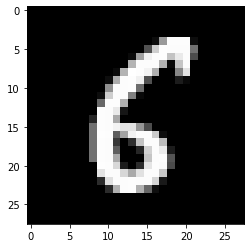

labeled: 4 -- classified: 9


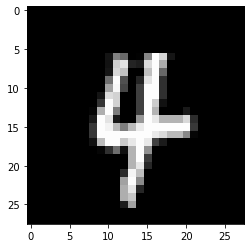

labeled: 7 -- classified: 9


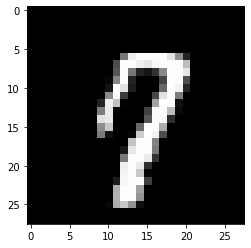

labeled: 4 -- classified: 6


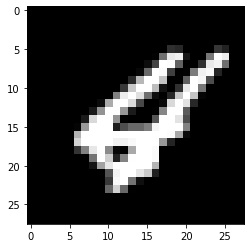

labeled: 6 -- classified: 1


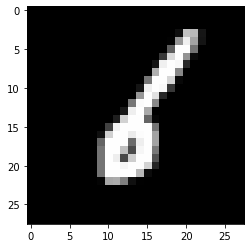

labeled: 6 -- classified: 8


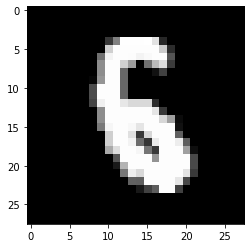

labeled: 0 -- classified: 6


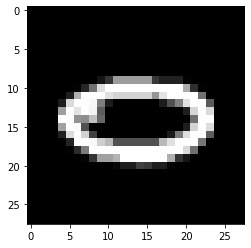

labeled: 9 -- classified: 4


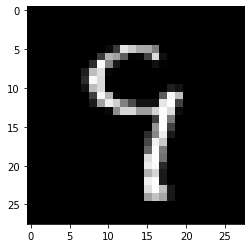

labeled: 7 -- classified: 9


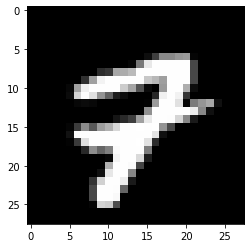

labeled: 8 -- classified: 4


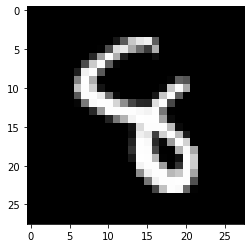

In [28]:
assess_results_2L()
#assess_results_3L()
#assess_results([ReLU, ReLU, ReLU, softmax], "4L")

In [29]:
# TODO dropout
pKeep = 0.8
weights = np.ones([5, 5])
binary_value = np.random.rand(weights.shape[0], weights.shape[1]) < pKeep
res = np.multiply(weights, binary_value)